# Greenness (gcc) Predictions:
##### Target Variables (#35): gcc of next 35 days
##### Features Used (#25): Last 7 days gcc value i.e. gcc90 value from (t-1)th to (t-5)th day + gcc90 value from (t-5)th to (t+14)th day of last year
##### Model used: Random Forest Regressor
##### Cross-validation strategy used: Time Series Cross Validator (In each split, test indices must be higher) 
##### Train Data: Till 2019
##### Test Data: 2020
##### Missing values in the train data has been has been filled with interpolate(method = time) function.

*** Model trained separately for each of the sites and hyperparemeters of Random Forest Regressor are also different for each of the sites.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import matplotlib.backends.backend_pdf
from matplotlib.dates import DayLocator, MonthLocator
from matplotlib.ticker import MaxNLocator
from datetime import date
import datetime
import pickle
pdf = matplotlib.backends.backend_pdf.PdfPages("PEG_RFR_gcc_predictions_result_model.pdf")

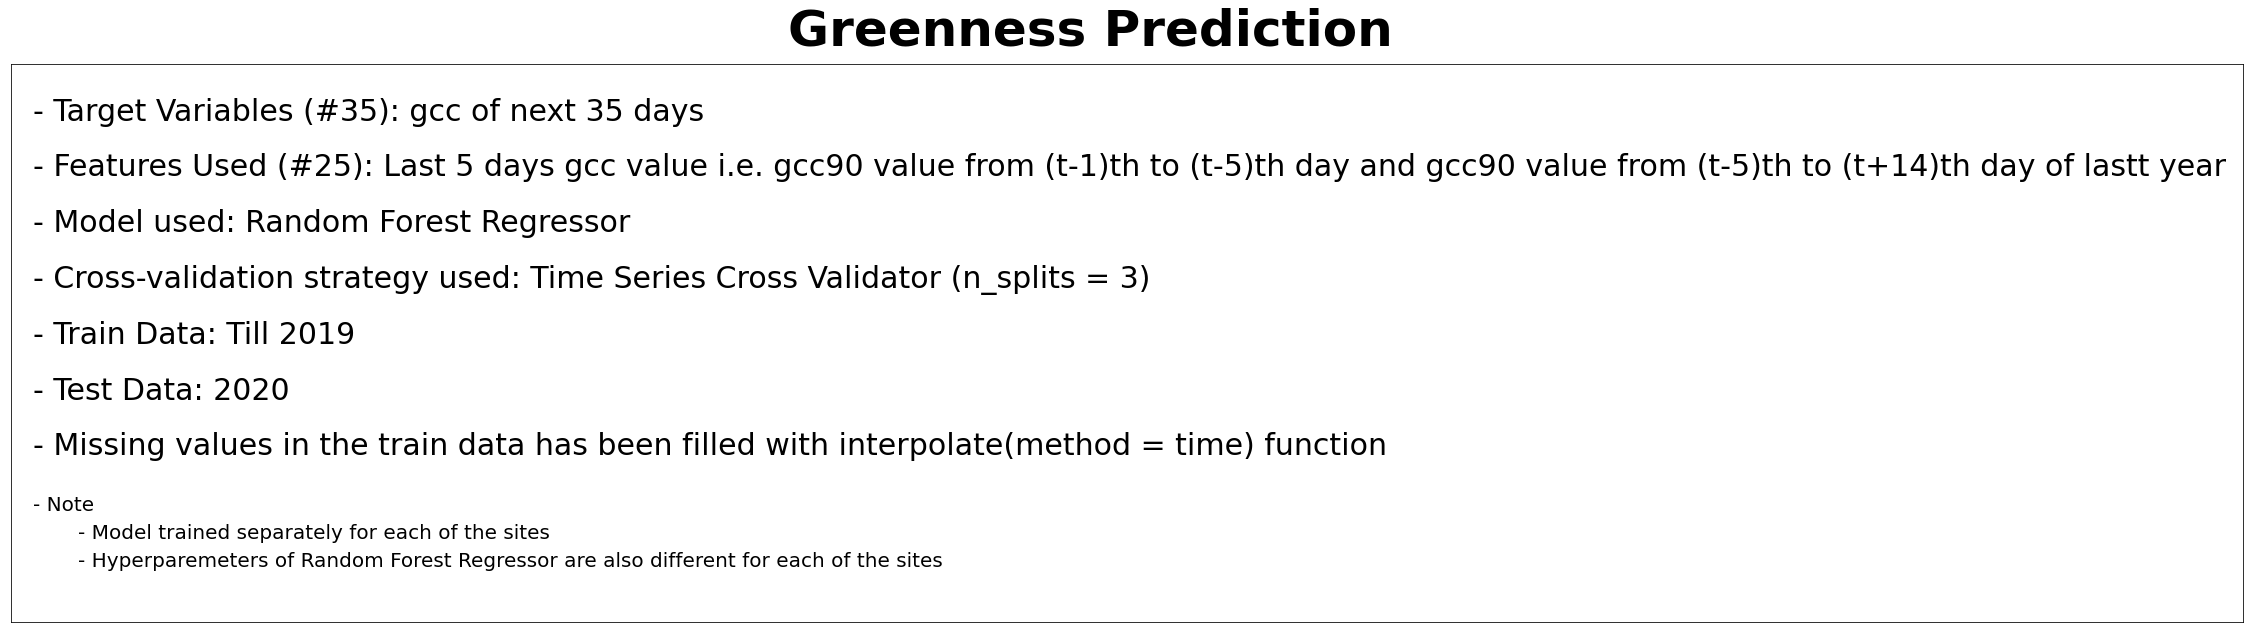

In [2]:
fig = plt.figure(figsize=(40,10))
fig.suptitle('Greenness Prediction', fontsize = 50, fontweight='bold')
#ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.90)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.text(0.01, 0.9, '- Target Variables (#35): gcc of next 35 days', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.8, '- Features Used (#25): Last 5 days gcc value i.e. gcc90 value from (t-1)th to (t-5)th day and gcc90 value from (t-5)th to (t+14)th day of lastt year', 
         fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.7, '- Model used: Random Forest Regressor', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.6, '- Cross-validation strategy used: Time Series Cross Validator (n_splits = 3)', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.5, '- Train Data: Till 2019', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.4, '- Test Data: 2020', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.3, '- Missing values in the train data has been filled with interpolate(method = time) function', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.2, '- Note', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.15, '- Model trained separately for each of the sites', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.1, '- Hyperparemeters of Random Forest Regressor are also different for each of the sites', fontsize = 20, horizontalalignment = 'left')
pdf.savefig()

## Data Preparation

In [3]:
# Importing the dataset gcc_weather.csv
url = "https://raw.githubusercontent.com/genophenoenvo/neon-datasets/main/pheno_images/gcc_weather.csv"
dataset = pd.read_csv(url)
print("Shape of imported dataset:" + str(dataset.shape))
print("\nColumns of imported dataset:")
print(dataset.columns)

Shape of imported dataset:(12496, 8)

Columns of imported dataset:
Index(['time', 'siteID', 'gcc_90', 'gcc_sd', 'radiation', 'max_temp',
       'min_temp', 'precip'],
      dtype='object')


In [4]:
# Creating columns year, month, day and setting the time as index to use 'shift' funtion() 
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['year'] = pd.DatetimeIndex(dataset['time']).year
dataset['month'] = pd.DatetimeIndex(dataset['time']).month
dataset['day'] = pd.DatetimeIndex(dataset['time']).day
dataset['year_month']= dataset['year'].map(str) + "-" + dataset['month'].map(str)
dataset = dataset.set_index("time")

In [5]:
# Selecting the required columns: siteID and gcc90 and date related columns
gcc_data = dataset[["siteID", "gcc_90", "year", "month", "day", "year_month"]]
print("Shape:" + str(gcc_data.shape))
site_list = gcc_data["siteID"].unique()
print("Sites:")
print(site_list)

Shape:(12496, 6)
Sites:
['HARV' 'BART' 'SCBI' 'STEI' 'UKFS' 'GRSM' 'DELA' 'CLBJ']


In [6]:
#Create dataframes for each of the sites and added those in a list 'site_data'
gcc_data_by_site = gcc_data.groupby("siteID")
site_data = []
for i in range(0,8):
    site_data.append(gcc_data_by_site.get_group(site_list[i]))

In [7]:
site_data[0]

,siteID,gcc_90,year,month,day,year_month
time,,,,,,
2016-12-13,HARV,0.32901,2016,12,13,2016-12
2016-12-14,HARV,0.32811,2016,12,14,2016-12
2016-12-15,HARV,0.32955,2016,12,15,2016-12
2016-12-16,HARV,0.32874,2016,12,16,2016-12
2016-12-17,HARV,0.33152,2016,12,17,2016-12
...,...,...,...,...,...,...
2021-03-19,HARV,0.32804,2021,3,19,2021-3
2021-03-20,HARV,0.32834,2021,3,20,2021-3
2021-03-21,HARV,0.32855,2021,3,21,2021-3


In [8]:
#Creating features by using shift() function
input_features = []
target_variables = ['gcc_90']
for k in range(0,8):
    for i in range(1,36):
        col_name_ahead = "gcc_90_(t+"+str(i)+")"
        if(k == 0):
            target_variables.append(col_name_ahead)
        site_data[k].loc[:,col_name_ahead] = site_data[k].loc[:,"gcc_90"].shift(-i)
    for i in range(1,6):
        col_name = "gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name)
        site_data[k].loc[:,col_name] = site_data[k].loc[:,"gcc_90"].shift(i)
    for i in range(1,6):
        col_name_last_year = "last_year_gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year)
        site_data[k].loc[:,col_name_last_year] = site_data[k].loc[:,"gcc_90"].shift(i+365)
    for i in range(0,15):
        col_name_last_year_ahead = "last_year_gcc_90_(t+"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year_ahead)
        site_data[k].loc[:,col_name_last_year_ahead] = site_data[k].loc[:,"gcc_90"].shift(365-i)

C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [10]:
print("Columns in each of the site's dataframe:")
site_data[0].columns

Columns in each of the site's dataframe:


Index(['siteID', 'gcc_90', 'year', 'month', 'day', 'year_month',
       'gcc_90_(t+1)', 'gcc_90_(t+2)', 'gcc_90_(t+3)', 'gcc_90_(t+4)',
       'gcc_90_(t+5)', 'gcc_90_(t+6)', 'gcc_90_(t+7)', 'gcc_90_(t+8)',
       'gcc_90_(t+9)', 'gcc_90_(t+10)', 'gcc_90_(t+11)', 'gcc_90_(t+12)',
       'gcc_90_(t+13)', 'gcc_90_(t+14)', 'gcc_90_(t+15)', 'gcc_90_(t+16)',
       'gcc_90_(t+17)', 'gcc_90_(t+18)', 'gcc_90_(t+19)', 'gcc_90_(t+20)',
       'gcc_90_(t+21)', 'gcc_90_(t+22)', 'gcc_90_(t+23)', 'gcc_90_(t+24)',
       'gcc_90_(t+25)', 'gcc_90_(t+26)', 'gcc_90_(t+27)', 'gcc_90_(t+28)',
       'gcc_90_(t+29)', 'gcc_90_(t+30)', 'gcc_90_(t+31)', 'gcc_90_(t+32)',
       'gcc_90_(t+33)', 'gcc_90_(t+34)', 'gcc_90_(t+35)', 'gcc_90_(t-1)',
       'gcc_90_(t-2)', 'gcc_90_(t-3)', 'gcc_90_(t-4)', 'gcc_90_(t-5)',
       'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)',
       'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)',
       'last_year_gcc_90_(t-5)', 'last_year_gcc_90_(t+0)',
       'last_year_gcc_

In [11]:
print("Input Features:\n" + str(input_features))
print("\nTarget Variables:\n" + str(target_variables))

Input Features:
['gcc_90_(t-1)', 'gcc_90_(t-2)', 'gcc_90_(t-3)', 'gcc_90_(t-4)', 'gcc_90_(t-5)', 'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)', 'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)', 'last_year_gcc_90_(t-5)', 'last_year_gcc_90_(t+0)', 'last_year_gcc_90_(t+1)', 'last_year_gcc_90_(t+2)', 'last_year_gcc_90_(t+3)', 'last_year_gcc_90_(t+4)', 'last_year_gcc_90_(t+5)', 'last_year_gcc_90_(t+6)', 'last_year_gcc_90_(t+7)', 'last_year_gcc_90_(t+8)', 'last_year_gcc_90_(t+9)', 'last_year_gcc_90_(t+10)', 'last_year_gcc_90_(t+11)', 'last_year_gcc_90_(t+12)', 'last_year_gcc_90_(t+13)', 'last_year_gcc_90_(t+14)']

Target Variables:
['gcc_90', 'gcc_90_(t+1)', 'gcc_90_(t+2)', 'gcc_90_(t+3)', 'gcc_90_(t+4)', 'gcc_90_(t+5)', 'gcc_90_(t+6)', 'gcc_90_(t+7)', 'gcc_90_(t+8)', 'gcc_90_(t+9)', 'gcc_90_(t+10)', 'gcc_90_(t+11)', 'gcc_90_(t+12)', 'gcc_90_(t+13)', 'gcc_90_(t+14)', 'gcc_90_(t+15)', 'gcc_90_(t+16)', 'gcc_90_(t+17)', 'gcc_90_(t+18)', 'gcc_90_(t+19)', 'gcc_90_(t+20)', 'gcc_90_(t+21)', 

In [12]:
# Create baseline gcc_90 by averaging last 3 years gcc value
for k in range(0,8):
    df =  site_data[k].copy()
    
    df.drop(pd.Timestamp("2020-02-29"), inplace = True, errors = 'ignore')
    
    baseline_df = df[["siteID"]]
    avg = pd.DataFrame()
    
    avg["ly_1"] = df.loc[:, "gcc_90"].shift(365)
    avg["ly_2"] = df.loc[:, "gcc_90"].shift(365*2)
    avg["ly_3"] = df.loc[:, "gcc_90"].shift(365*3)
    avg["mean"] = avg.mean(axis = 1, skipna = True)
    baseline_df["baseline_gcc_90"] = avg["mean"]
    
    for i in range(1,35):
        baseline_col_name_ahead = "baseline_gcc_90_(t+"+str(i)+")"
        col_name_ahead = "gcc_90_(t+"+str(i)+")"
        avg = pd.DataFrame()
        avg["ly_1"] = df.loc[:, col_name_ahead].shift(365)
        avg["ly_2"] = df.loc[:, col_name_ahead].shift(365*2)
        avg["ly_3"] = df.loc[:, col_name_ahead].shift(365*3)
        avg["mean"] = avg.mean(axis = 1, skipna = True)
        baseline_df[baseline_col_name_ahead] = avg["mean"]
    
    baseline_df.drop("siteID", inplace = True, axis =1)
    site_data[k] = site_data[k].join(baseline_df, how ='outer')

<ipython-input-12-d63c0c992b32>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df["baseline_gcc_90"] = avg["mean"]
<ipython-input-12-d63c0c992b32>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df[baseline_col_name_ahead] = avg["mean"]
C:\Users\palde\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [13]:
site_data[0].shape[0]

1562

In [13]:
data_count = pd.DataFrame(index = [2016, 2017, 2018, 2019, 2020, 2021])
for k in range(0,8):
    data_count[site_list[k]] =  site_data[k].groupby("year").count().iloc[:, 1]
data_count

,HARV,BART,SCBI,STEI,UKFS,GRSM,DELA,CLBJ
2016,19,18,19,0,0,0,16,0
2017,347,330,353,57,0,306,353,25
2018,365,362,344,356,48,365,365,355
2019,358,343,363,363,352,350,361,365
2020,315,362,362,365,334,365,344,358
2021,79,82,82,82,79,82,82,82


## Training

In [14]:
best_models = []
overall_rmse_score = []
overall_r2_score = []
target_variable_wise_score = []
interpolated_train_data = []
true_results = []
predicted_results = []
train_test_size = {"Site_Name": [], "Train_Size": [],"Test_Size" : []}

for k in range(0,8):
    print("\n" + str(site_list[k]) + ":\n")
    
    train_data = site_data[k][site_data[k].columns.intersection(input_features+target_variables)].loc[:'2019', :]
    train_data.interpolate(method='time', inplace=True, #limit = 15, limit_area='inside', limit_direction='both'
                          )
    interpolated_train_data.append(train_data)
    train_data.dropna(inplace = True)
    
    test_data = site_data[k][site_data[k].columns.intersection(input_features+target_variables)].loc['2020', :]
    test_data.dropna(inplace = True)
    
    X_train = train_data[train_data.columns.intersection(input_features)]
    Y_train = train_data[train_data.columns.intersection(target_variables)]
    X_test = test_data[test_data.columns.intersection(input_features)]
    Y_test = test_data[test_data.columns.intersection(target_variables)]
    
    train_test_size["Site_Name"].append(site_list[k])
    train_test_size["Train_Size"].append(X_train.shape[0])
    train_test_size["Test_Size"].append(X_test.shape[0])

    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of Y_train:" + str(Y_train.shape))
    print("Shape of X_test:" + str(X_test.shape))
    print("Shape of Y_test:" + str(Y_test.shape))
    
    model = RandomForestRegressor(random_state = 0)
    param_search = {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth': [i for i in range(5,15)]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score.append(rmse)
    overall_r2_score.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


HARV:

Shape of X_train:(744, 25)
Shape of Y_train:(744, 36)
Shape of X_test:(204, 25)
Shape of Y_test:(204, 36)
RMSE of Training Data: -0.02257338862228422
Model:RandomForestRegressor(max_depth=13, max_features='log2', n_estimators=10,
                      random_state=0)
explained_variance: 0.9463123992089832
RMSE: 0.010127174507759244
R2: 0.9448330513202107
------------------------------------------------------------------------

BART:

Shape of X_train:(743, 25)
Shape of Y_train:(743, 36)
Shape of X_test:(208, 25)
Shape of Y_test:(208, 36)
RMSE of Training Data: -0.01762250471805279
Model:RandomForestRegressor(max_depth=13, max_features='sqrt', random_state=0)
explained_variance: 0.9365598945374329
RMSE: 0.01189104468124201
R2: 0.930604456452647
------------------------------------------------------------------------

SCBI:

Shape of X_train:(744, 25)
Shape of Y_train:(744, 36)
Shape of X_test:(242, 25)
Shape of Y_test:(242, 36)
RMSE of Training Data: -0.020696210468583345
Model:

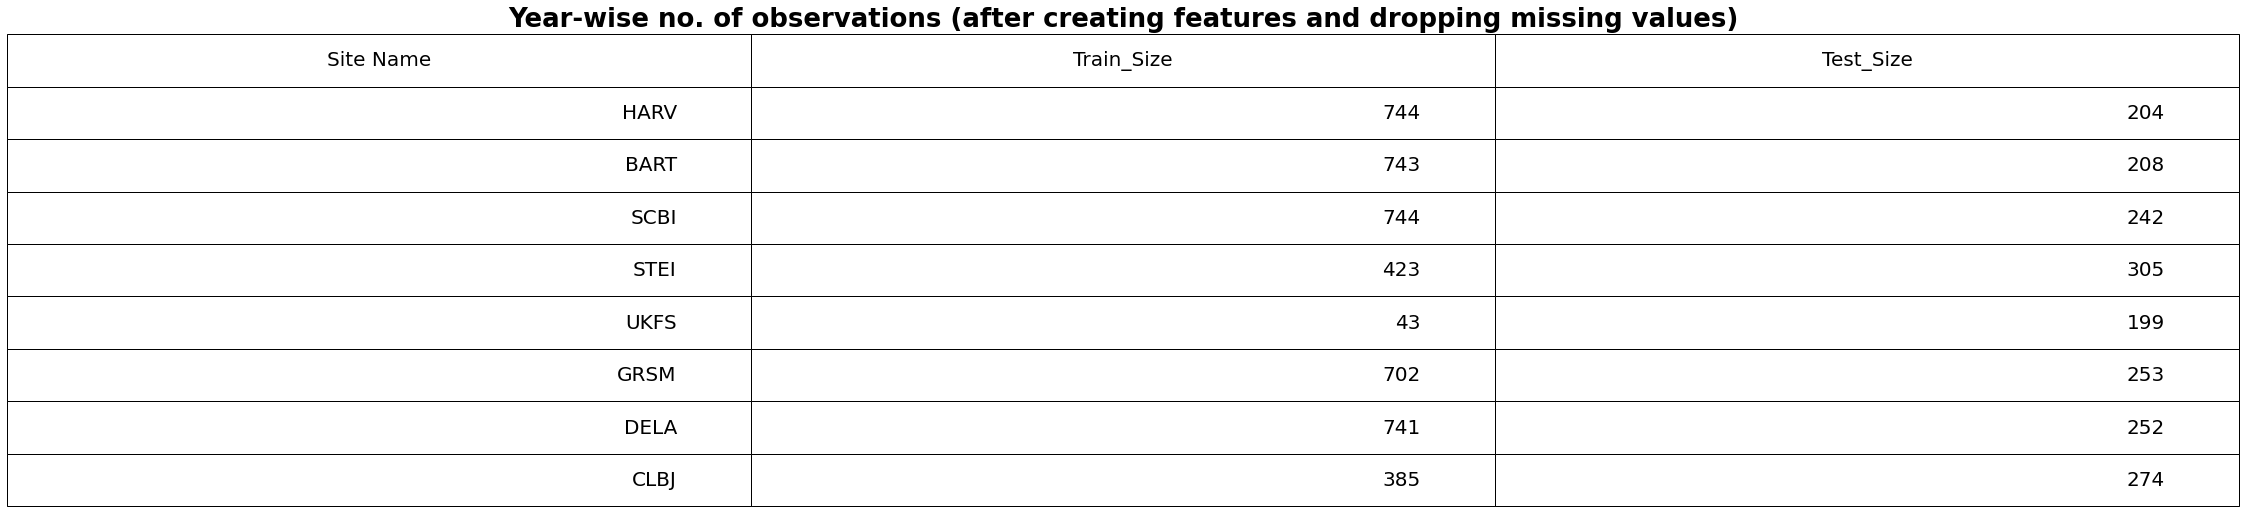

In [15]:
train_test_size_df = pd.DataFrame(train_test_size)
plt.figure(figsize=(40,8))
table = plt.table(np.array(train_test_size_df), 
                      colLabels = ['Site Name', 'Train_Size', 'Test_Size'],
                      loc='center')
table.set_fontsize(20)
table.scale(1,4)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.title("Year-wise no. of observations (after creating features and dropping missing values)", fontsize = 26, fontweight = 'bold')
plt.subplots_adjust(top=0.950)
#plt.subplots_adjust(bottom=0.10)
fig.tight_layout()
pdf.savefig()

In [16]:
site_list_modified = list(site_list[:4]) + list(site_list[5:])
overall_rmse_score_modified = list(overall_rmse_score[:4]) + list(overall_rmse_score[5:])
overall_r2_score_modified = list(overall_r2_score[:4]) + list(overall_r2_score[5:])

fig, ax = plt.subplots(1, 2, figsize = (40, 12), dpi=80)
fig.suptitle("Site- wise Overall Performance Evaluation", fontsize=30, fontweight='bold')
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[0].set_ylabel("RMSE", fontsize = 26)
ax[0].set_ylim(0.005, 0.020)
ax[0].set_title("Root Mean Squared Error", fontsize = 32) 
ax[0].plot(site_list_modified, overall_rmse_score_modified, color = 'black', marker='o')
ax[0].yaxis.grid()

ax[1].set_ylabel("R-Squared Score", fontsize = 30)
ax[1].set_title("R-Squared Score", fontsize = 32)
ax[1].set_ylim(0.60, 1.00)
ax[1].plot(site_list_modified, overall_r2_score_modified, color = 'black', marker='o')
#ax[1].axhline(y=0.85, linestyle = "--")
ax[1].tick_params(axis='both', which='major', labelsize = 30)
ax[1].yaxis.grid()
pdf.savefig()
plt.close()

In [17]:
fig, ax = plt.subplots(4, 2, figsize = (40, 50), dpi = 140)
ax = ax.flatten()
fig.suptitle("Target Variable Wise RMSE", fontsize=26, fontweight='bold')

for k in range(0,8):
    rmse_dict = {"Target":[],"RMSE":[]}
    Y_pred = predicted_results[k]
    Y_true = true_results[k]
    for i in range(0,36):
        #explained_variance = metrics.explained_variance_score(Y_true[:, i], Y_pred[:, i])
        mse = metrics.mean_squared_error(Y_true[:, i], Y_pred[:, i])
        rmse = np.sqrt(mse)
        rmse_dict["Target"].append(i+1)
        rmse_dict["RMSE"].append(rmse)
        #r2 = metrics.r2_score(Y_true[:, i], Y_pred[:, i])
        #print("\nTarget Variable: "+str(i+1))
        #print("explained_variance: " + str(explained_variance))
        #print("MSE: "+ str(mse))
        #print("RMSE: "+ str(rmse))
        #print("R2: "+ str(r2))
    ax[k].set_title(site_list[k], fontsize=32)
    #ax[k].text(0, 0.046, str(best_models[k]), fontsize=16)
    ax[k].plot(rmse_dict["Target"], rmse_dict['RMSE'], color = 'black', lw=1, marker = 'o')
    ax[k].set_ylim(0.0025,0.025)
    ax[k].set_ylabel("RMSE", fontsize=30)
    ax[k].set_xlabel("Target Variables (Today and Next 35 days)", fontsize=30) 
    ax[k].tick_params(axis='both', which='major', labelsize=30)
    
plt.subplots_adjust(top=0.95)
pdf.savefig()
plt.close()

In [18]:
site_list_modified = list(site_list[:4]) + list(site_list[5:])
best_models_modified = list(best_models[:4]) + list(best_models[5:])
best_models_modified
fig, ax = plt.subplots(7, 1, figsize = (40, 120), gridspec_kw={'width_ratios': [10]}, dpi = 100)
ax = ax.flatten()
#fig.suptitle("Feature Importances", fontsize=26, fontweight='bold')
for k in range(0,7):
    imp = best_models_modified[k].feature_importances_
    indices = np.argsort(imp)
    #features = X_train.columns
    ax[k].set_title(site_list_modified[k], fontsize=34)
    ax[k].barh(range(len(indices)), imp[indices], color = 'gray', align='center')
    ax[k].set_yticks(range(len(indices)))
    ax[k].set_yticklabels([input_features[i] for i in indices])
    ax[k].set_xlabel("Relative Importance", fontsize = 30) 
    ax[k].tick_params(axis='both', which='major', labelsize=30)
    ax[k].set_xlim(0.0, 0.6)
plt.subplots_adjust(top=0.98)
plt.savefig("feature_imporatance_approach1.png")
pdf.savefig()
plt.close()

## Validation

In [19]:
# Test with 2020 data
predicted_site_data = []
for k in range(0,8):
    test_data = site_data[k].loc['2020', :]
    test_data.dropna(subset = (input_features + target_variables), inplace = True)
    predicted_site_data.append(test_data)

<ipython-input-19-ba17586dc5e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.dropna(subset = (input_features + target_variables), inplace = True)
<ipython-input-19-ba17586dc5e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.dropna(subset = (input_features + target_variables), inplace = True)
<ipython-input-19-ba17586dc5e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.dropna(subset = (input_featu

In [20]:
# Predict gcc_90 for 2020
for k in range(0,8):
    Y_pred = predicted_results[k]
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90", value = Y_pred[:, 0])
    for i in range(1,35):
        predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
        predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = predicted_col_name, 
                                      value = Y_pred[:, i])

In [21]:
df = predicted_site_data[0]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[0], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [22]:
df = predicted_site_data[1]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[1], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [23]:
df = predicted_site_data[2]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[2], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [24]:
df = predicted_site_data[3]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[3], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [25]:
df = predicted_site_data[4]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[4], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [26]:
df = predicted_site_data[5]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[5], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [27]:
df = predicted_site_data[6]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[6], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [28]:
df = predicted_site_data[7]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[7], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [29]:
df = predicted_site_data[0]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[0], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-29-3848d64a2f1a>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-29-3848d64a2f1a>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-29-3848d64a2f1a>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-29-3848d64a2f1a>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [30]:
df = predicted_site_data[1]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[1], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-30-918595c38872>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-30-918595c38872>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-30-918595c38872>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-30-918595c38872>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [31]:
df = predicted_site_data[2]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[2], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-31-3f2c731696fe>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-31-3f2c731696fe>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-31-3f2c731696fe>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-31-3f2c731696fe>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [32]:
df = predicted_site_data[3]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[3], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-32-9fe68579878b>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-32-9fe68579878b>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-32-9fe68579878b>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-32-9fe68579878b>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [33]:
df = predicted_site_data[4]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[4], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-33-72ae6bc1e656>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-33-72ae6bc1e656>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-33-72ae6bc1e656>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-33-72ae6bc1e656>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [34]:
df = predicted_site_data[5]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[5], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-34-44ff1d388fcf>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-34-44ff1d388fcf>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-34-44ff1d388fcf>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-34-44ff1d388fcf>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [35]:
df = predicted_site_data[6]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[6], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-35-c39360d27076>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-35-c39360d27076>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-35-c39360d27076>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-35-c39360d27076>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [36]:
df = predicted_site_data[7]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[7], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-36-b1214a7f9f84>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-36-b1214a7f9f84>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-36-b1214a7f9f84>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-36-b1214a7f9f84>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [37]:
# Preiction for 2021
current_year_data = []
for k in range(0,8):
    current_year_data.append(site_data[k].loc['2021', :].dropna(subset = input_features))

In [38]:
current_year_predictions = []
for k in range(0,8):
    current_year_input = current_year_data[k][current_year_data[k].columns.intersection(input_features)]
    current_year_predictions.append(best_models[k].predict(current_year_input))

In [39]:
for k in range(0,8):
    predicted_result = current_year_predictions[k]
    current_year_data[k].insert(loc = len(current_year_data[k].columns), column = "predicted_gcc_90", value = predicted_result[:, 0])
    for i in range(1,35):
        predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
        current_year_data[k].insert(loc = len(current_year_data[k].columns), column = predicted_col_name, 
                                      value = predicted_result[:, i])

In [40]:
df = current_year_data[0]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[0], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-40-8d675b8dfe58>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-40-8d675b8dfe58>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-40-8d675b8dfe58>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-40-8d675b8dfe58>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [41]:
df = current_year_data[1]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[1], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-41-c880b7a6a20a>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-41-c880b7a6a20a>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-41-c880b7a6a20a>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-41-c880b7a6a20a>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [42]:
df = current_year_data[2]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[2], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-42-12cfd98a2d1c>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-42-12cfd98a2d1c>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-42-12cfd98a2d1c>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-42-12cfd98a2d1c>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [43]:
df = current_year_data[3]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[3], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-43-4fcfcd4ac6c1>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-43-4fcfcd4ac6c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-43-4fcfcd4ac6c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-43-4fcfcd4ac6c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [44]:
df = current_year_data[4]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[4], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-44-de6108eba3c1>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-44-de6108eba3c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-44-de6108eba3c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-44-de6108eba3c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

<ipython-input-44-de6108eba3c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-44-de6108eba3c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-44-de6108eba3c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)


In [45]:
df = current_year_data[5]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[5], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-45-1d89a00e4e5e>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-45-1d89a00e4e5e>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-45-1d89a00e4e5e>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-45-1d89a00e4e5e>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [46]:
df = current_year_data[6]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[6], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-46-4eabbac577fc>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-46-4eabbac577fc>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-46-4eabbac577fc>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-46-4eabbac577fc>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [47]:
df = current_year_data[7]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[7], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-47-448c69318039>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-47-448c69318039>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-47-448c69318039>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-47-448c69318039>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [48]:
pdf.close()

In [49]:
# Train model for the site UKFS
UKFS_train_data = site_data[4][site_data[4].columns.intersection(input_features+target_variables)]
UKFS_train_data.interpolate(method='time', inplace=True, #limit = 15, limit_area='inside', limit_direction='both'
                          )
interpolated_train_data[4] = UKFS_train_data
UKFS_train_data.dropna(inplace = True)
    
UKFS_X_train = UKFS_train_data[UKFS_train_data.columns.intersection(input_features)]
UKFS_Y_train = UKFS_train_data[UKFS_train_data.columns.intersection(target_variables)]

    
print("Shape of X_train:" + str(UKFS_X_train.shape))
print("Shape of Y_train:" + str(UKFS_Y_train.shape))
    
model = RandomForestRegressor(random_state = 0)
param_search = {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth': [i for i in range(5,15)]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_Y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models[4] = best_model
print("RMSE of UKFS Training Data: " + str(best_score))
print("Model:" + str(best_model))

<ipython-input-49-7d5d31b5be3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UKFS_train_data.interpolate(method='time', inplace=True, #limit = 15, limit_area='inside', limit_direction='both'
<ipython-input-49-7d5d31b5be3a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UKFS_train_data.dropna(inplace = True)


Shape of X_train:(491, 25)
Shape of Y_train:(491, 36)
RMSE of UKFS Training Data: -0.03292163574635119
Model:RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=10,
                      random_state=0)


In [51]:
#Save the model
for k in range(0,8):
    file_name = "model_"+site_list[k]+".pkl"
    pickle.dump(best_models[k], open(file_name, 'wb'))